# モデルの実装のまとめと学習の導入
本単元は、総まとめに当たる単元になるので重要事項を再度確認しよう。

> 本講座のタスク
* タスクの内容：画像に写っている１文字の数字を何か判定する
    * 用意したデータ：60,000枚の手書き数字が写ったラベル付きの画像データ(MNISTデータセット)
    * 目的：精度を重視する

> 機械学習の流れ
1. ~アルゴリズムの選択~：ディープラーニングを選択
2. ~前処理~：MNISTデータセットには必要なし
3. モデルの学習
4. 評価・検証

この単元では**MLPモデルを学習させる方法**をメインに「3.モデルの学習」,「4.評価・検証」の実装をしていくぞ！
具体的には、モデルの学習に使う`train()`関数と、評価・検証に使う`test()`関数の実装だ。

## この単元の目標
- MLPモデルを学習できるようになろう
- MLPモデルをテストできるようになろう

# モデルの実装のまとめと学習の導入
本単元は、総まとめに当たる単元になるので重要事項を再度確認しよう。

> 本講座のタスク
* タスクの内容：画像に写っている１文字の数字を何か判定する
    * 用意したデータ：60,000枚の手書き数字が写ったラベル付きの画像データ(MNISTデータセット)
    * 目的：精度を重視する

> 機械学習の流れ
1. ~アルゴリズムの選択~：ディープラーニングを選択
2. ~前処理~：MNISTデータセットには必要なし
3. モデルの学習
4. 評価・検証

この単元では**MLPモデルを学習させる方法**をメインに「3.モデルの学習」,「4.評価・検証」の実装をしていくぞ！
具体的には、モデルの学習に使う`train()`関数と、評価・検証に使う`test()`関数の実装だ。

## この単元の目標
- MLPモデルを学習できるようになろう
- MLPモデルをテストできるようになろう

## 0. 準備

In [42]:
# 本章で使うモジュールのインポート
from torch import utils
from torchvision import datasets
import torchvision.transforms as transforms

import torch
from torch import nn, optim
from torch.nn import functional as F

### 【MNISTデータセット】
まずは、学習に使うデータセットを準備しよう。(MNISTについて忘れた人は単元1を確認しよう)  

pytorchには、データセットがライブラリとしていくつか用意（実際にはダウンロードする関数）されており、MNISTもその1つだ。  

以下のコードを実行すれば、
* データセットの用意(ダウンロード)
* 過学習回避のため、用意したデータセットを学習用と検証用に分ける  
    * 下記のプログラムでは最初から別れたデータをダウンロードしている
* ミニバッチごとにデータを纏める  
    * バッチサイズは100、ランダムにバッチデータを決めることで効果的な学習になる

In [43]:
## こうやってダウンロードして使うことができるよ
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())  # 学習用データセット
train_loader = utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)  # ミニバッチごとにデータを纏める(学習時にはshuffle=True)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())  # 検証用データセット
test_loader = utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)  # ミニバッチごとにデータを纏める(学習時にはshuffle=False)

In [23]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("MPS is available")
else:
    print("MPS is not available")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

MPS is available


MNIST データは、次の4つのファイルで構成されます。 役割ごとにファイルが分かれています。

train-images-idx3-ubyte: 学習用の画像セット
train-labels-idx1-ubyte: 学習用のラベルセット
t10k-images-idx3-ubyte: 検証用の画像セット
t10k-labels-idx1-ubyte: 検証用のラベルセット

MNIST のファイルをデータをダウンロードすると JPEG などの画像が入っているのかと思いきや、予想とは違い、次のような仕様のデータファイルが含まれていました。 1ファイルの中に複数の画像やラベルのデータが入っており、ファイルを読込む際にはその仕様に則る必要があります。 ただし、後述する各種ライブラリのクラス・関数を利用すれば簡単にデータを読込むことができます。

ラベルデータ (train-labels-idx1-ubyte / t10k-labels-idx1-ubyte)
　ラベルデータが保存されたファイル(train-labels-idx1-ubyte / t10k-labels-idx1-ubyte)は、次のような仕様になっています。

offset	type	value	description
0000	32 bit integer	0x00000801(2049)	識別子(定数)
0004	32 bit integer	60000 or 10000	ラベルデータの数
0008	unsigned byte	0 ～ 9	1つ目のデータのラベル
0009	unsigned byte	0 ～ 9	2つ目のデータのラベル
....	....	....	....
xxxx	unsigned byte	0 ～ 9	最後のデータのラベル
ラベルは、画像が何の数字を表すかの 0 から 9 までの数値です。

画像データ (train-images-idx3-ubyte / t10k-images-idx3-ubyte)
　画像データが保存されたファイル(train-images-idx3-ubyte / t10k-images-idx3-ubyte)は、次のような仕様になっています。

offset	type	value	description
0000	32 bit integer	0x00000803(2051)	識別子(定数)
0004	32 bit integer	60000	画像データの数
0008	32 bit integer	28	1画像あたりのデータ行数
0012	32 bit integer	28	1画像あたりのデータ列数
0016	unsigned byte	0 ～ 255	1つめの画像の1ピクセル目の値
0017	unsigned byte	0 ～ 255	1つめの画像の2ピクセル目の値
....	....	....	....
xxxx	unsigned byte	0 ～ 255	最後の画像の784ピクセル目の値
ピクセルの値は、0 から 255 までの値で、0 が白を, 255 が黒を表します。

In [24]:
test_loader

### 【モデルの定義】
次に、学習を行うためのモデルを準備しよう。  
行うタスクは、**「28*28画素の白黒画像を10クラス分類する」**事なので、  
入力ノードの数は784（=28*28）個で、出力ノードの数は10個で良いだろう。

よって、以下の条件のMLPモデルをクラスとして定義する。  
- 「入力層、中間層、出力層」のノードの数が「784（=28×28）、512、10」
- 中間層の出力に活性化関数`relu()`を適用
- 損失関数は`MSELoss()`
- 最適化関数は`Adam()`

In [44]:
class mlp_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 10)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters())

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## 1. train()関数の実装
それでは、**`train()`関数の実装**を行っていこう。
実装にあたり、気をつける点が2点あるので
- 2次元の画像であるテンソルを1次元のテンソルに変換する。
- 損失を求めるために正解データをone-hotベクトル化する。

MLPはその構造上、**2次元以上である画像データをその形状のまま入力として受け取る事ができない。**  
よって、画像を行や列で区切るなどして**1次元のテンソルに変換してからモデルに入力**する。  
今回は、形状変形のために`reshape()`を使おう。

また、モデルの出力は**各クラスの予測確率に相関したベクトル**であるのに対し、**正解ラベルはクラス名（0~9の値）**であるため、  
そのままではMSEを計算する事ができない。  
そこで、正解ラベルを「one-hotベクトルに変換」することで、モデルの予測結果との損失計算を可能にする。  
【one-hotベクトル化の例】
- 正解ラベル「1」 → `[0,1,0,0,0,0,0,0,0,0]` （=「1」である確率が1の確率ベクトル）
- 正解ラベル「7」 → `[0,0,0,0,0,0,0,1,0,0]` （=「7」である確率が1の確率ベクトル）

以上のことを踏まえて、例題を見ながら`train()`関数の実装方法を確認しよう。

【例題】 `train()`関数を実装する。 
`train()`関数では、引数に`model`（学習するモデル）と`train_loader`（学習データローダ）を受け取り、  
`train_loader`を「ミニバッチ=ある程度の数のデータのまとまり」ごとにループさせて学習を行う。  
この1ループは、次の流れで進む。
1. バッチごとのデータをモデルへ順伝播させる
2. 正解ラベルと比較して損失を計算する
3. 損失から最適化を行う
4. 次のバッチへ

これに加えて**「画像データの1次元化」**と**「正解ラベルのone-hotベクトル化」**を忘れないようにしよう。  
`torch.eye(クラス数)[バッチごとのデータ]`と記述すると、`バッチごとのデータ`の1要素に対してone-hotベクトル化することができる。

In [26]:
def train(model, train_loader):
    # 今は学習時であることを明示するコード
    model.train()
    # ミニバッチごとにループさせる,train_loaderの中身を出し切ったら1エポックとなる
    for batch_imgs, batch_labels in train_loader:
        batch_imgs = batch_imgs.reshape(-1, 28*28*1).to(device)  # 画像データを1次元に変換
        labels = torch.eye(10)[batch_labels].to(device)  # 正解ラベルをone-hotベクトルへ変換

        outputs = model(batch_imgs)  # 順伝播
        model.optimizer.zero_grad()  # 勾配を初期化（前回のループ時の勾配を削除）
        loss = model.criterion(outputs, labels)  # 損失を計算
        loss.backward()  # 逆伝播で勾配を計算
        model.optimizer.step()  # 最適化
    return

以上のコードが、モデルの学習を行うプログラムの核にあたる。  

しかし、このままでは学習進捗の確認ができないので、「正答率」と「損失」を出力できるように、以下のように追記する。  

In [37]:
import matplotlib.pyplot as plt

def train(model, train_loader):
    # 今は学習時であることを明示するコード
    model.train()

    ### 追記部分1 ###
    # 正しい予測数、損失の合計、全体のデータ数を数えるカウンターの0初期化
    total_correct = 0
    total_loss = 0
    total_data_len = 0
    ### ###

    # ミニバッチごとにループさせる,train_loaderの中身を出し切ったら1エポックとなる
    for batch_imgs, batch_labels in train_loader:

        batch_imgs = batch_imgs.reshape(-1, 28*28*1).to(device)   # 画像データを1次元に変換
        labels = torch.eye(10)[batch_labels].to(device)   # 正解ラベルをone-hotベクトルへ変換
        plt.imshow(batch_imgs)
        plt.show()

        outputs = model(batch_imgs)  # 順伝播
        model.optimizer.zero_grad()  # 勾配を初期化（前回のループ時の勾配を削除）
        loss = model.criterion(outputs, labels)  # 損失を計算
        loss.backward()  # 逆伝播で勾配を計算
        model.optimizer.step()  # 最適化
       
        ### 追記部分2 ###
        # ミニバッチごとの正答率と損失を求める
        _, pred_labels = torch.max(outputs, axis=1)  # outputsから必要な情報(予測したラベル)のみを取り出す。
        batch_size = len(batch_labels)  # バッチサイズの確認
        for i in range(batch_size):  # データ一つずつループ,ミニバッチの中身出しきるまで
            total_data_len += 1  # 全データ数を集計
            if pred_labels[i] == batch_labels[i]:
                total_correct += 1 # 正解のデータ数を集計
        total_loss += loss.item()  # 全損失の合計

    # 今回のエポックの正答率と損失を求める
    accuracy = total_correct/total_data_len*100  # 予測精度の算出
    loss = total_loss/total_data_len  # 損失の平均の算出
    return accuracy, loss
    ### ###

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

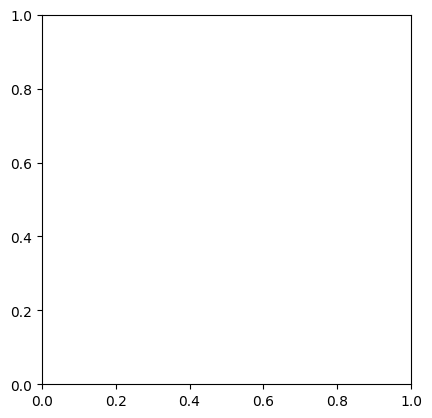

In [38]:
# モデルを宣言する
model = mlp_net().to(device)

# 学習させ、その結果を表示する
acc, loss = train(model, train_loader)
print(f'正答率: {acc}, 損失: {loss}')

- ```
正答率： {95.0前後}, 損失: {0.0002前後}
```
と表示されていれば成功だ。

【問題】 新しいMLPモデル`mlp_net_2()`をクラスとして定義して、学習、結果を例題と同様に表示しよう。  
ただし、以下の条件にあるようにハイパーパラメータを指定すること。
- 宣言する`mlp_net_2()`のインスタンス名（変数名）は`model_2`とすること
- 中間層のノードの数を`256`にする
- `optim.Adam()`の引数`lr`に`0.01`を指定する

In [30]:
class mlp_net_2(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.01)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [32]:
# モデルを宣言する
model_2 = mlp_net_2().to(device)

# 学習させ、その結果を表示する
acc, loss = train(model_2, train_loader)
print(f'正答率: {acc}, 損失: {loss}')

正答率: 89.19, 損失: 0.0002787030518831064


In [36]:
# 学習させ、その結果を表示する
acc, loss = train(model_2, train_loader)
print(f'正答率: {acc}, 損失: {loss}')

acc, loss = train(model_2, train_loader)
print(f'正答率: {acc}, 損失: {loss}')

acc, loss = train(model_2, train_loader)
print(f'正答率: {acc}, 損失: {loss}')

正答率: 94.39999999999999, 損失: 0.00014445836887850115
正答率: 94.53166666666667, 損失: 0.00014237657270083824
正答率: 94.47833333333332, 損失: 0.00014311055287253113


- ```
正答率： {90.0前後}, 損失: {0.00025前後}
```
と表示されていれば成功だ。
- 恐らく、例題よりも正答率は下がり、損失は大きくなったのではないだろうか。  
このように、ハイパーパラメータは学習に大きく影響するということを覚えておこう。

## test()関数の実装
次は、テストデータを使った評価を行う`test()`関数を実装する。  
とは言っても、`train()`関数から「損失計算」や「最適化」の要素を取り除けば良いだけだ。  

In [15]:
def test(model, data_loader):
    # モデルを評価モードにする
    model.eval()
    # 正しい予測数、全体のデータ数を数えるカウンターの0初期化
    total_data_len = 0
    total_correct = 0

    for batch_imgs, batch_labels in data_loader:
        outputs = model(batch_imgs.reshape(-1, 28*28*1))  # 順伝播（=予測）
         
        # ミニバッチごとの集計
        _, pred_labels = torch.max(outputs, axis=1)  # outputsから必要な情報(予測したラベル)のみを取り出す。
        batch_size = len(pred_labels)  # バッチサイズの確認
        for i in range(batch_size):  # データ一つずつループ,ミニバッチの中身出しきるまで
            total_data_len += 1  # 全データ数を集計
            if pred_labels[i] == batch_labels[i]:
                total_correct += 1 # 正解のデータ数を集計

    # 1エポック分の集計
    acc = 100.0 * total_correct/total_data_len  # 予測精度の算出
    return acc

【例題】 学習させた`mlp_net`と`test_loader`を使って、テストを行う。

In [16]:
test_acc = test(model, test_loader)
print(test_acc)

97.13


- 正答率はおよそ`95%`前後になるだろう。それであれば成功だ。

【問題】 学習させた`mlp_net_2`と`test_loader`を使って、テストを行ってみよう。テストデータの正答率を出力すれば良い。

In [15]:
test_acc = test(model_2, test_loader)
print(test_acc)

93.39


- 恐らく正答率は例題と同等かそれ以下になるだろう。それであれば成功だ。
- ハイパーパラメータの影響によって、学習データ・テストデータともに予測精度が落ちている可能性が高い。

## まとめ
MLPモデルを実装し、テストした！

Pytorchを使ってのプログラミングは理論より、簡単だったのではないだろうか？

